In [1]:
# set env LD_LIBRARY_PATH to install_path
install_path = "/Users/yumengxu/Project/Physics/cwb/cwb_source/tools/install/lib"

import os

os.environ['LD_LIBRARY_PATH'] = install_path
from pycwb import logger_init
logger_init()

# load user parameters
from pycwb.config import Config, CWBConfig
cwb_config = CWBConfig('./config.ini')
cwb_config.export_to_envs()
config = Config('./user_parameters.yaml')
config.ifo

Welcome to JupyROOT 6.26/10
2023-02-07 16:53:39,326 - pycwb.config.cwb_config - INFO - Loaded config from ./config.ini
2023-02-07 16:53:39,327 - pycwb.config.cwb_config - INFO - Environment variables loaded


['L1', 'H1', 'V1']

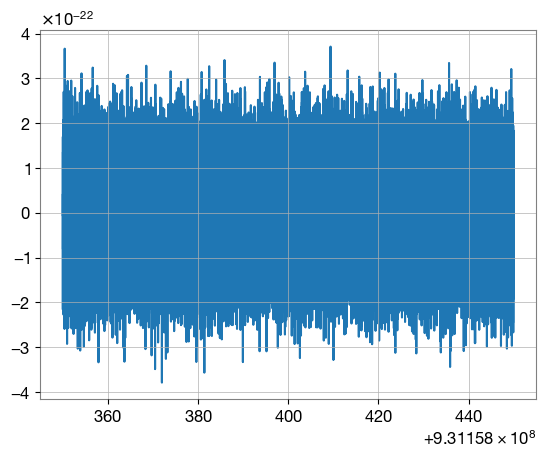

In [4]:
from pycwb.modules.read_data import generate_noise

noise = generate_noise(f_low=30.0, sample_rate=1024.0, duration=100, start_time = 931158400 - 50)
noise.plot()

In [10]:
# generate injection from pycbc
from pycbc.waveform import get_td_waveform
hp, hc = get_td_waveform(approximant="IMRPhenomPv3",
                         mass1=20,
                         mass2=20,
                         spin1z=0.9,
                         spin2z=0.4,
                         inclination=1.23,
                         coa_phase=2.45,
                         distance=500,
                         delta_t=1.0/noise.sample_rate,
                         f_lower=32)
declination = 0.65
right_ascension = 4.67
polarization = 2.34
gps_end_time = 931158400

from pycwb.modules.read_data import project_to_detector
strain = project_to_detector(hp, hc, right_ascension, declination, polarization, config.ifo, gps_end_time)

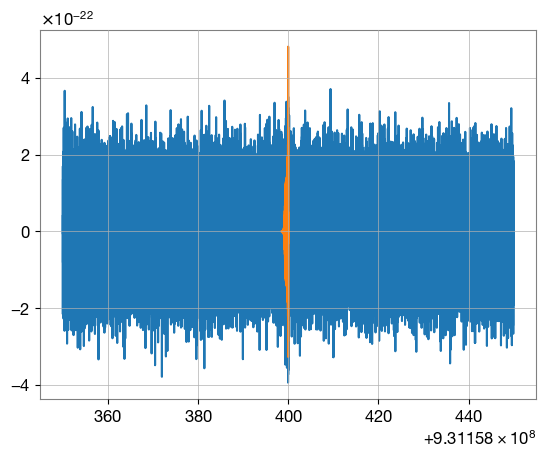

In [11]:
injected = noise.add_into(strain[0])
injected.plot()
strain[0].plot()

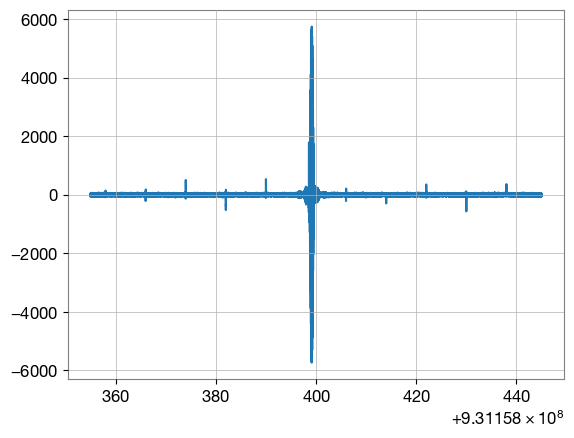

In [24]:
whitened = injected.whiten(6, 10)
whitened.plot()

## Input data

(931158395.0, 931158403.0)

Filter length = 577,  norm = 0.9999999947541458


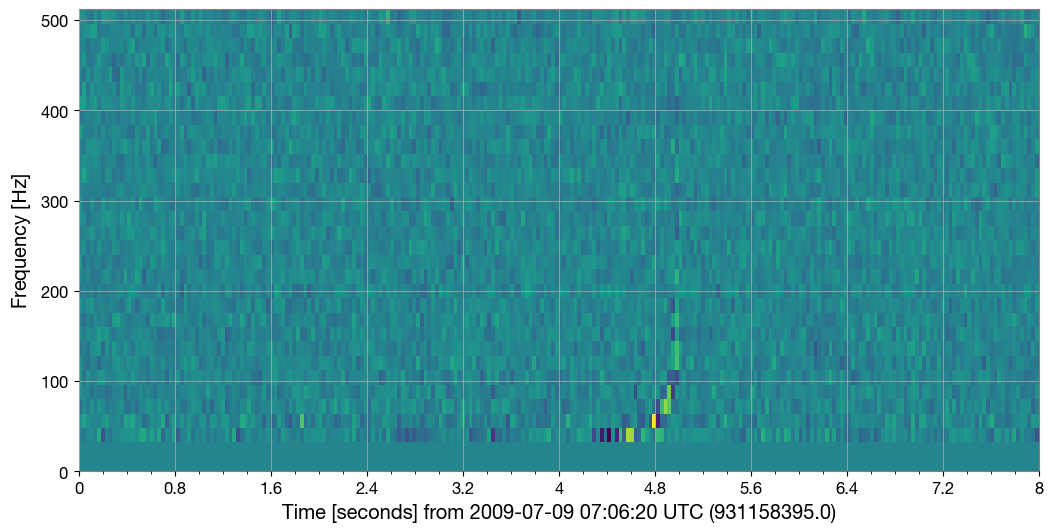

In [60]:
from pycwb.utils import convert_pycbc_timeseries_to_wavearray
wavearray = convert_pycbc_timeseries_to_wavearray(injected)

import ROOT
import numpy as np

wdm = ROOT.WDM(np.double)(32, 64, 4, 8)
tf_map = ROOT.WSeries(np.double)(wavearray, wdm)
tf_map.Forward()

from pycwb.utils import WSeries_to_matrix
import matplotlib.pyplot as plt

from gwpy.spectrogram import Spectrogram
Spectrogram(WSeries_to_matrix(tf_map).T, t0=tf_map.start(), dt=1/tf_map.wRate, f0=tf_map.f_low, df=tf_map.resolution()
            ).plot()
plt.xlim(gps_end_time-5, gps_end_time+3)

In [56]:
1/tf_map.rate()

0.0009765625

## Regression

(1500.0, 1700.0)

Filter length = 1537,  norm = 0.9999999999707183


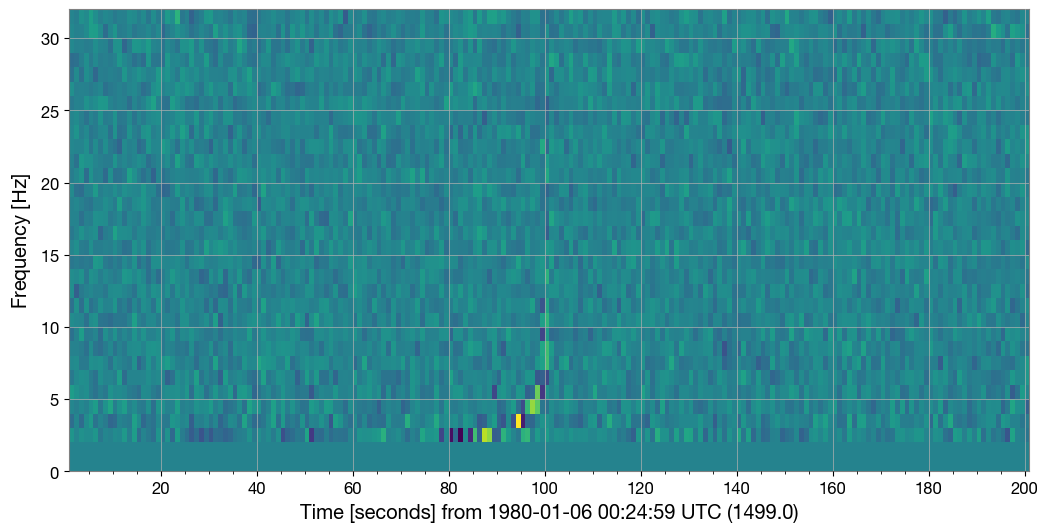

In [13]:
from pycwb.modules.data_conditioning import regression, whitening
data_reg = regression(config, wavearray)

tf_map = ROOT.WSeries(np.double)(data_reg, wdm)
tf_map.Forward()

from pycwb.utils import WSeries_to_matrix
import matplotlib.pyplot as plt

from gwpy.spectrogram import Spectrogram
Spectrogram(WSeries_to_matrix(tf_map).T).plot()
plt.xlim(1500, 1700)

## Whitening

2023-02-07 15:59:53,312 - pycwb.modules.data_conditioning.whitening - INFO - calculate noise rms
2023-02-07 15:59:53,319 - pycwb.modules.data_conditioning.whitening - INFO - high pass filtering at 16Hz
2023-02-07 15:59:53,319 - pycwb.modules.data_conditioning.whitening - INFO - whiten  0 phase WSeries
2023-02-07 15:59:53,321 - pycwb.modules.data_conditioning.whitening - INFO - whiten 90 phase WSeries


(1500.0, 1700.0)

Filter length = 3073,  norm = 0.9999999999707190


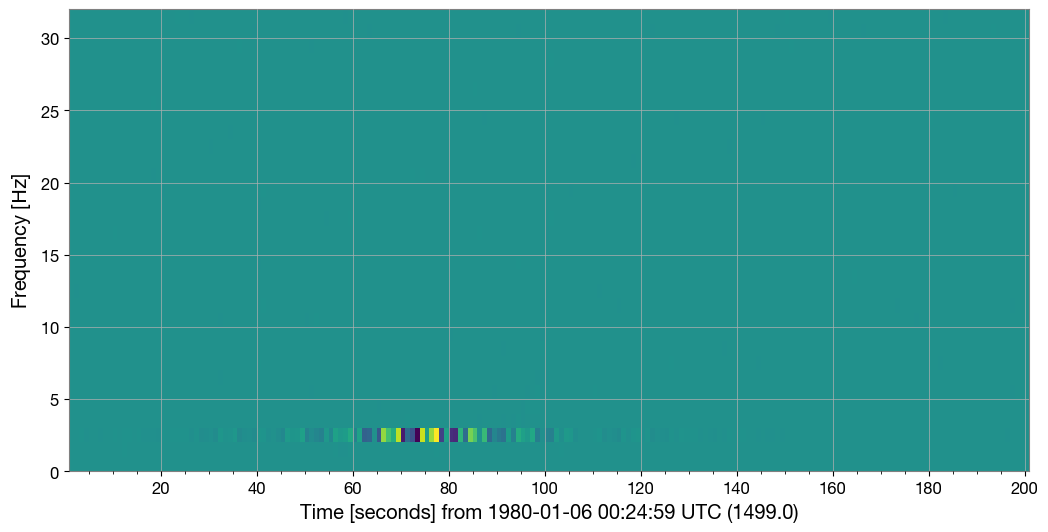

In [19]:
from pycwb.modules.data_conditioning import regression, whitening
data_w_reg = whitening(config, data_reg)

tf_map = ROOT.WSeries(np.double)(data_w_reg['TFmap'], wdm)
tf_map.Forward()

from pycwb.utils import WSeries_to_matrix
from gwpy.spectrogram import Spectrogram
Spectrogram(WSeries_to_matrix(tf_map).T).plot()
plt.xlim(1500, 1700)

(1300.0, 1500.0)

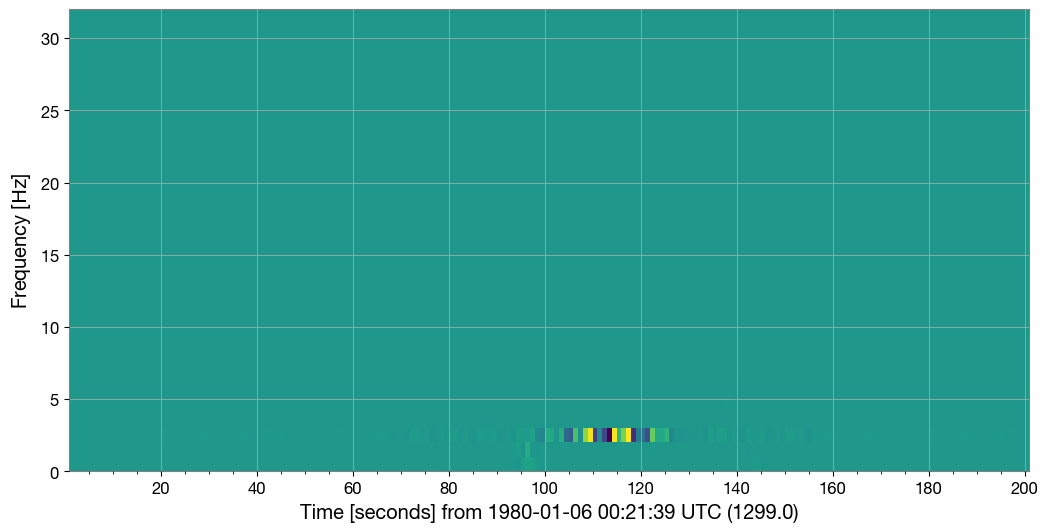

In [29]:
whitened_wavearray = convert_pycbc_timeseries_to_wavearray(whitened)
tf_map = ROOT.WSeries(np.double)(whitened_wavearray, wdm)
tf_map.Forward()

from pycwb.utils import WSeries_to_matrix
from gwpy.spectrogram import Spectrogram
Spectrogram(WSeries_to_matrix(tf_map).T).plot()
plt.xlim(1300, 1500)
